In [4]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objs as go
import plotly
plotly.__version__

'4.5.0'

In [5]:
sns.set(style='darkgrid')
mpl.rcParams['figure.figsize'] = (16,19)

In [6]:
dataPath_Raw = ("data/PROF_small_flat_table.csv")
#dataPath_Processed = ("../data/processed/")

pd.set_option("display.max_rows", 500)

In [7]:
df_analyse = pd.read_csv(dataPath_Raw, sep=";")
df_analyse.sort_values('date', ascending = True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [8]:
df_analyse.Germany[35]

27

In [9]:
N0 = 1000000
beta = 0.4
gamma = 0.1

# Reproduction number beta/gamma

# S + I + R = N

I0 = 27
S0 = N0 - I0
R0 = 0

print(S0)

999973


In [10]:
def SIR_model(SIR, beta, gamma):
    
    S,I,R = SIR
    dS = -beta * S * I/N0
    dI = beta * S * I/N0 - gamma * I
    dR = gamma * I
    
    return([dS, dI, dR])
    

In [11]:
SIR = np.array([S0,I0,R0])

propagation_rates = pd.DataFrame(columns={'Susceptible':S0,
                                          'Infected':I0,
                                          'Recovered':R0                                                  
                                         })
                                 
for each in np.arange(100):
    new_delta_vector = SIR_model(SIR, beta, gamma)
    SIR = SIR + new_delta_vector
    
    propagation_rates = propagation_rates.append({'Susceptible':SIR[0],
                                                  'Infected':SIR[1],
                                                  'Recovered':SIR[2],                         
                                                },ignore_index=True
                                                )
                                 



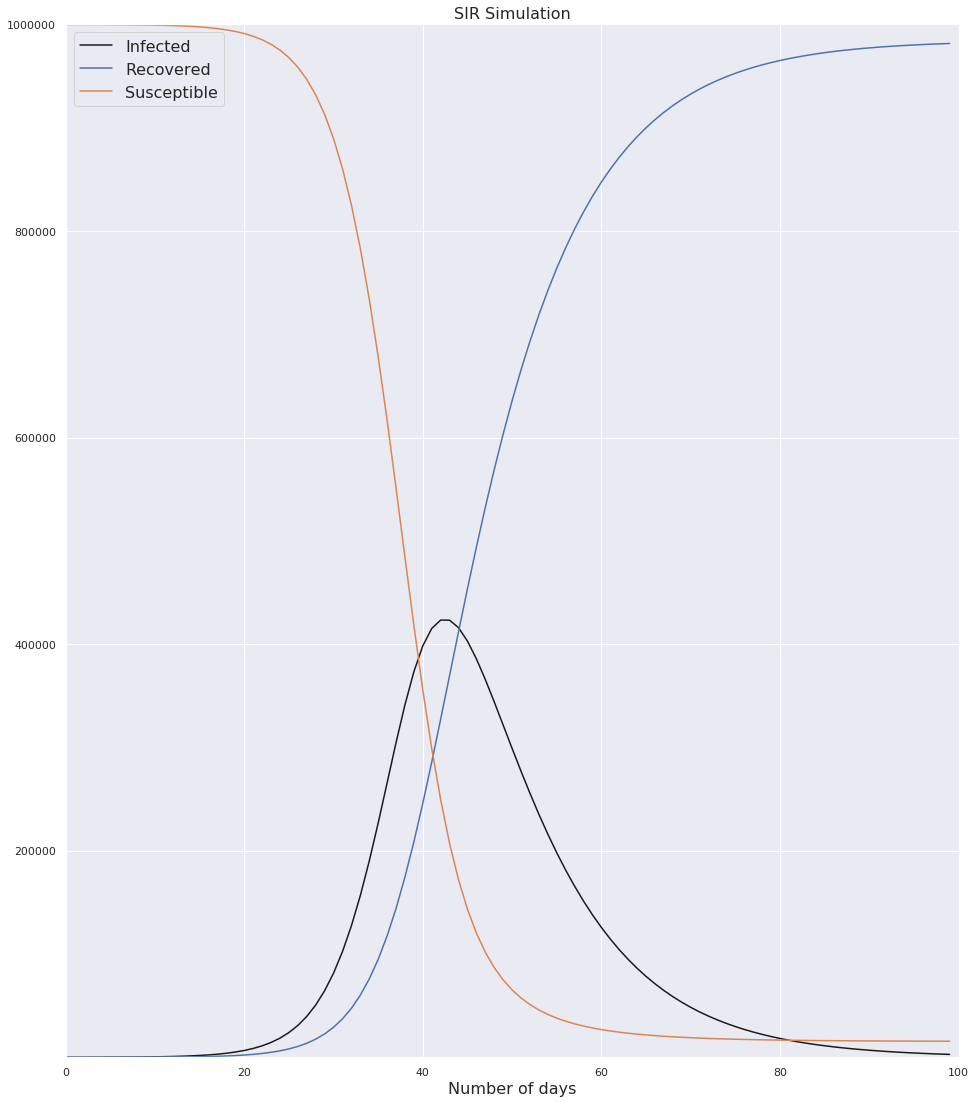

In [12]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.Infected, label = 'Infected', color= 'k')
ax1.plot(propagation_rates.index, propagation_rates.Recovered, label = 'Recovered')
ax1.plot(propagation_rates.index, propagation_rates.Susceptible, label = 'Susceptible')

ax1.set_ylim(10,1000000)
ax1.set_xlim(0,100)
ax1.set_yscale('linear')
ax1.set_title('SIR Simulation', size= 16)
ax1.set_xlabel('Number of days', size=16)
ax1.legend(loc='best',
          prop={'size':16})

## Fitting the parameters

In [13]:
from scipy import optimize
from scipy import integrate

In [14]:
ydata = np.array(df_analyse.Germany[36:])   #90
time = np.arange(len(ydata))

In [15]:
I0 = ydata[0]
S0 = 100000
R0 = 0
beta

0.4

In [16]:
print(I0)

46


In [17]:
def SIR_model_fit(SIR, time, beta, gamma):
    
    S,I,R = SIR
    dS = -beta * S * I/N0
    dI = beta * S * I/N0 - gamma * I
    dR = gamma * I
    
    return([dS, dI, dR])
    

In [18]:
def fit_odeint(x,beta,gamma):
    return integrate.odeint(SIR_model_fit, (S0,I0,R0), time, args=(beta, gamma))[:,1]

# [,:1] infected rate

In [19]:
# Integrate

popt = [0.4, 0.1]  #beta, gamma

fit_odeint(time, *popt)

array([46.        , 43.32115291, 40.79828236, 38.42230979, 36.18468463,
       34.07735377, 32.09273257, 30.22367763, 28.46346118, 26.80574691,
       25.24456723, 23.77430179, 22.38965734, 21.08564877, 19.857581  ,
       18.70103227, 17.61183818, 16.58607675, 15.6200543 , 14.71029221,
       13.85351431, 13.0466352 , 12.28674911, 11.57111943, 10.89716887,
       10.26247024,  9.66473764,  9.10181828,  8.57168472,  8.07242756,
        7.60224861,  7.1594544 ,  6.74245002,  6.3497335 ,  5.97989029,
        5.63158824,  5.30357275,  4.99466232,  4.70374422,  4.42977055,
        4.17175442,  3.92876641,  3.69993125,  3.48442463,  3.28147025,
        3.09033703,  2.91033644,  2.74082009,  2.58117733,  2.43083308,
        2.28924575,  2.15590529,  2.03033137,  1.91207163,  1.80070006,
        1.69581544,  1.59703995,  1.50401776])

In [20]:
popt, pcov = optimize.curve_fit(fit_odeint, time, ydata)
perr = np.sqrt(np.diag(pcov))


In [21]:
print('Standard deviation errors : ', str(perr), 'Infection Start : ', ydata[0])


Standard deviation errors :  [0.01361813 0.00030352] Infection Start :  46


In [22]:
fitted = fit_odeint(time, *popt)

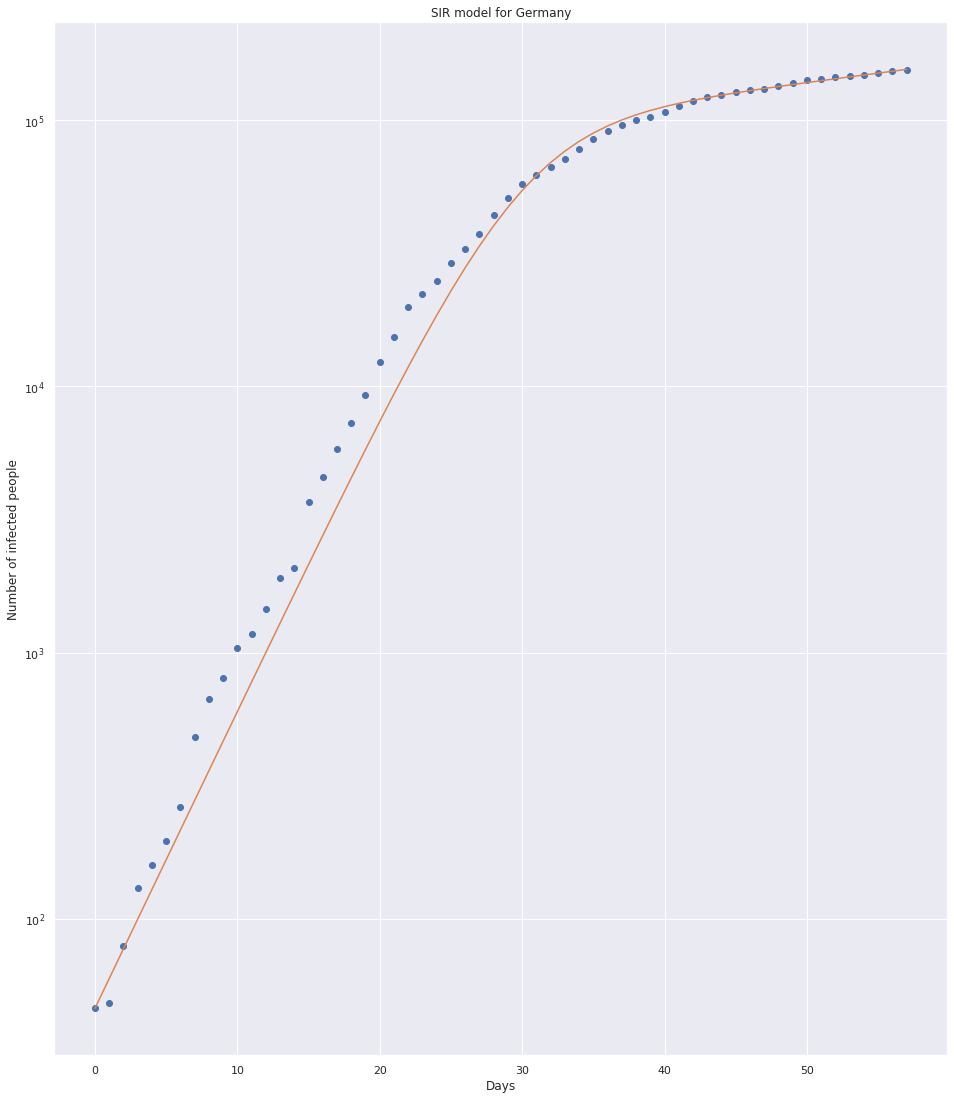

Optimal Parameters : beta =  2.410880872909639 gamma =  -0.01603710144483167
Reproduction number, R0 :  -150.33145990896014


In [23]:
plt.semilogy(time, ydata, 'o')
plt.semilogy(time, fitted)
plt.title('SIR model for Germany')
plt.ylabel('Number of infected people')
plt.xlabel('Days')
plt.show()

print('Optimal Parameters : beta = ', popt[0], 'gamma = ', popt[1])
print('Reproduction number, R0 : ', popt[0]/popt[1])

## Dynamic Beta 

In [24]:
t_initial = 38
t_intro_measures = 21
t_hold = 21
t_relax = 21

beta_max = 2.410880872909639
beta_min = 0.11
gamma = -0.01603710144


pd_beta = np.concatenate((np.array(t_initial*[beta_max]),
                          np.linspace(beta_max, beta_min, t_intro_measures),
                          np.array(t_hold * [beta_min]),
                          np.linspace(beta_min, beta_max, t_relax)
                        ))

pd_beta

array([2.41088087, 2.41088087, 2.41088087, 2.41088087, 2.41088087,
       2.41088087, 2.41088087, 2.41088087, 2.41088087, 2.41088087,
       2.41088087, 2.41088087, 2.41088087, 2.41088087, 2.41088087,
       2.41088087, 2.41088087, 2.41088087, 2.41088087, 2.41088087,
       2.41088087, 2.41088087, 2.41088087, 2.41088087, 2.41088087,
       2.41088087, 2.41088087, 2.41088087, 2.41088087, 2.41088087,
       2.41088087, 2.41088087, 2.41088087, 2.41088087, 2.41088087,
       2.41088087, 2.41088087, 2.41088087, 2.41088087, 2.29583683,
       2.18079279, 2.06574874, 1.9507047 , 1.83566065, 1.72061661,
       1.60557257, 1.49052852, 1.37548448, 1.26044044, 1.14539639,
       1.03035235, 0.91530831, 0.80026426, 0.68522022, 0.57017617,
       0.45513213, 0.34008809, 0.22504404, 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11   

In [27]:
SIR = np.array([S0,I0,R0])

propagation_rates = pd.DataFrame(columns={'Susceptible':S0,
                                          'Infected':I0,
                                          'Recovered':R0                                                  
                                         })
                                 
for each_beta in pd_beta:
    new_delta_vector = SIR_model(SIR, each_beta, gamma)
    SIR = SIR + new_delta_vector
    
    propagation_rates = propagation_rates.append({'Susceptible':SIR[0],
                                                  'Infected':SIR[1],
                                                  'Recovered':SIR[2],                         
                                                },ignore_index=True
                                                )
                                 



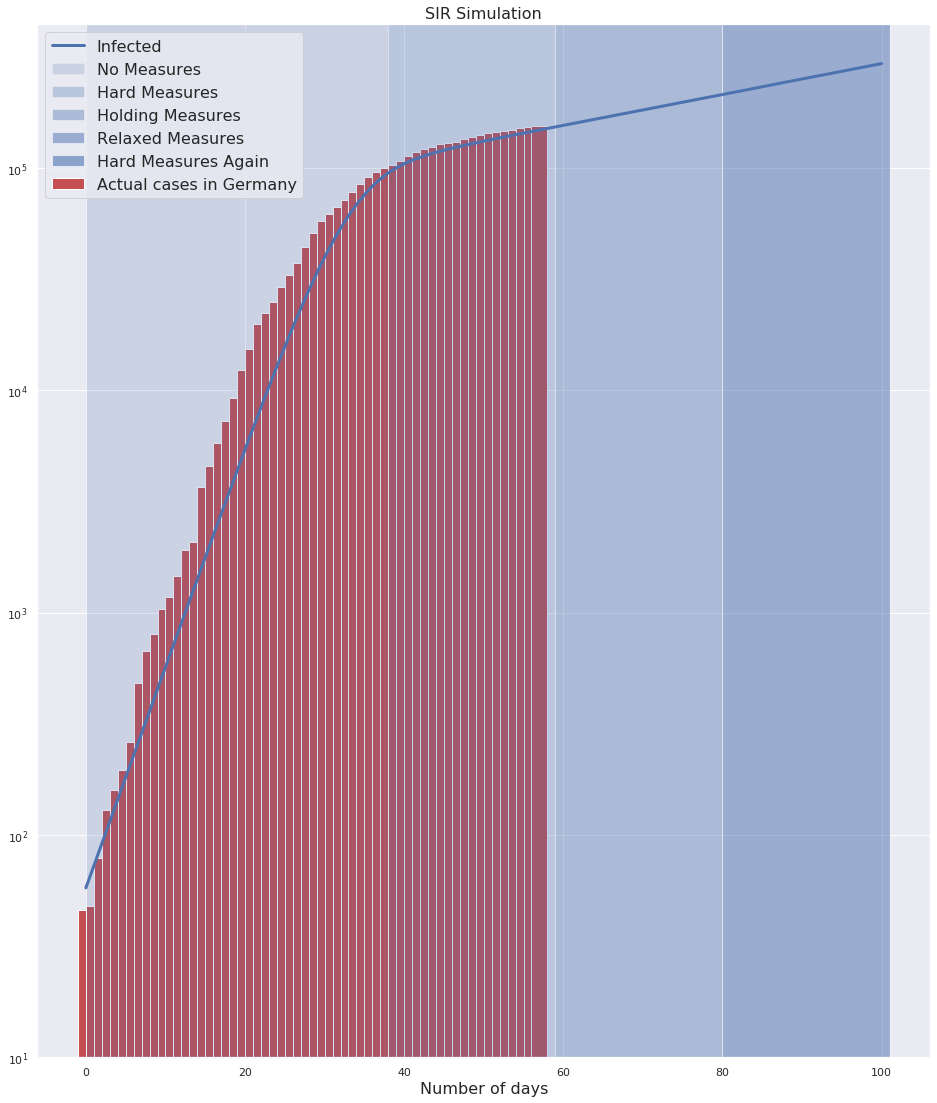

In [26]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.Infected, label = 'Infected', linewidth = 3)
#ax1.plot(propagation_rates.index, propagation_rates.Recovered, label = 'Recovered')
#ax1.plot(propagation_rates.index, propagation_rates.Susceptible, label = 'Susceptible')

ax1.bar(np.arange(len(ydata)), ydata, width=2, label = 'Actual cases in Germany', color = 'r')
t_phases = np.array([t_initial, t_intro_measures, t_hold, t_relax]).cumsum()

ax1.axvspan(0, t_phases[0], facecolor='b', alpha=0.2, label="No Measures")
ax1.axvspan(t_phases[0], t_phases[1], facecolor='b', alpha=0.3, label="Hard Measures")
ax1.axvspan(t_phases[1], t_phases[2], facecolor='b', alpha=0.4, label="Holding Measures")
ax1.axvspan(t_phases[2], t_phases[3], facecolor='b', alpha=0.5, label="Relaxed Measures")
ax1.axvspan(t_phases[3], len(propagation_rates.Infected),facecolor='b', alpha=0.6, label="Hard Measures Again")

ax1.set_ylim(10,1.5*max(propagation_rates.Infected))
#ax1.set_xlim(0,100)
ax1.set_yscale('log')
ax1.set_title('SIR Simulation', size= 16)
ax1.set_xlabel('Number of days', size=16)
ax1.legend(loc='best',
          prop={'size':16})